# Time Fronts
generate figure 2

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bighorn
import seaborn as sns
from kaooi.coordinates import coords, depths
from matplotlib.colorbar import ColorbarBase
import cmps
from dotenv import load_dotenv
import os
from tqdm import tqdm
from scipy import signal

# load .env file
env_path = '../.env'
_ = load_dotenv(env_path)

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

/gscratch/coenv/jhrag/miniconda/envs/kb/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Load timefronts

In [2]:
hydrophones = ['AXBA1','AXEC2','AXCC1', 'LJ01C','LJ01A']
gts_climate_d = {}
for node in hydrophones:
    fnr = f'{os.environ["data_directory"]}timefront/iw_climate_{node}_Gfz_real.nc'
    fni = f'{os.environ["data_directory"]}timefront/iw_climate_{node}_Gfz_imag.nc'

    gf = xr.open_dataarray(fnr) + 1j*xr.open_dataarray(fni)
    gt = bighorn.convert_to_time(gf, 300, 10, (37.5, 112.5))
    gts_climate_d[node] = 20*np.log10(np.abs(gt))
gts_climate = xr.Dataset(gts_climate_d)

In [3]:
hydrophones = ['AXBA1','AXEC2','AXCC1','LJ01C','LJ01A']
gts_climate_iw_d = {}
for node in hydrophones:
    fnr = f'{os.environ["data_directory"]}timefront/climate_{node}_Gfz_real.nc'
    fni = f'{os.environ["data_directory"]}timefront/climate_{node}_Gfz_imag.nc'

    gf = xr.open_dataarray(fnr) + 1j*xr.open_dataarray(fni)
    gt = bighorn.convert_to_time(gf, 300, 10, (37.5, 112.5))
    gts_climate_iw_d[node] = 20*np.log10(np.abs(gt))
    
gts_climate_iw = xr.Dataset(gts_climate_iw_d)

## Create Plot

There's an issue with the xlims

In [4]:
cmap = cmps.rocket_r_white()

In [ ]:
ylims = {
    'AXCC1':(1700,0),
    'AXEC2':(1700,0),
    'AXBA1':(2700,0),
    'LJ01A':(3000,0),
    'LJ01C':(650,0),
    'LJ01D':(100,0),
    'HYS14':(900,0),
}
xlims = {
    'AXCC1':(4, 9),
    'AXEC2':(5,10),
    'AXBA1':(0, 5),
    'LJ01A':(-2.5, 4),
    'LJ01C':(4, 10),
    'LJ01D':(0, 10),
    'HYS14':(1, 7),
}

titles = {
    'AXCC1':'AXCC1, AXEC2',
    'AXBA1':'AXBA1, LJ03A, PC03A',
    'LJ01A':'LJ01A, HYS1B, PC01A',
    'LJ01C':'LJ01C',
    'LJ01D':'LJ01D',
    'HYS14':'HYS14',
}

fs_integer = {
    'AXCC1':252,
    'AXEC2':252,
    'AXBA1':253,
    'LJ01C':269,
    'PC01A':268,
    'PC03A':253,
    'HYS14':268,
    'LJ01A':268,
}

delta_t = {
    'AXCC1':1.33,
    'AXEC2':1.59,
    'AXBA1':1.69,
    'LJ01C':2.24,
    'LJ01A':2.41,
    'PC03A':1.45,
}

xlims_abs = {}
for node in hydrophones:
    xlims_abs[node] = (xlims[node][0] + fs_integer[node]*10 + delta_t[node], xlims[node][1] + fs_integer[node]*10 + delta_t[node])

plt.rcParams.update({'font.size':8})
fig, axes = plt.subplots(5,2, figsize=(6.67,6.5))

letters = ['(a)','(b)','(c)','(d)','(e)','(f)']

hydrophones_plot = ['AXCC1','AXEC2','AXBA1','LJ01C','LJ01A']
# add letters
for k, ax in enumerate(axes[:,0].flatten()):
    ax.text(
        0.015,
        0.85,
        letters[k],
        transform=ax.transAxes,
        fontsize=8,
        zorder=100,
        bbox=dict(facecolor='white', edgecolor='k', pad=1, linewidth=0.5)
    )

# make ticks be inside plot
for ax in axes.flatten():
    ax.tick_params(axis='y', direction='in', length=1.8, width=0.75)
        
# remove y labels from second row
for k, ax in enumerate(axes[:,1].flatten()):
    ax.set_yticklabels('')

# Plot climate wavefronts
for k, ax in enumerate(axes[:,0].flatten()):
    node = hydrophones_plot[k]
    plt.sca(ax)
    gts_plot = gts_climate[node].assign_coords({'time':gts_climate[node].time+fs_integer[node]*10 + delta_t[node]})
    climate_plot = gts_plot.plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
    if node == 'LJ01A': # Plot time [10,20]
        gts_plot.assign_coords({'time':gts_plot.time-10}).plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
        pass

    if node == 'HYS14':
        plt.hlines(depths['HYS14']+20, xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    else:
        plt.hlines(depths[node], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'AXBA1':
        plt.hlines(depths['PC03A'], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'LJ01A':
        plt.hlines(depths['PC01A'], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)

    if k == 4:
        plt.xlabel('time [s]', labelpad=-1)
    else:
        plt.xlabel('')
        
    plt.ylabel('depth [m]', labelpad=-1)
    plt.ylim(ylims[node])
    plt.xlim(xlims_abs[node])
    plt.yticks(rotation=60)

# Plot climate + IW wavefronts
for k, ax in enumerate(axes[:,1].flatten()):

    node = hydrophones_plot[k]
    
    plt.sca(ax)
    gts_plot = gts_climate_iw[node].assign_coords({'time':gts_climate_iw[node].time + fs_integer[node]*10 + delta_t[node]})
    climate_iw_plot = gts_plot.plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
    if node == 'LJ01A': # Plot time [10,20]
        gts_plot.assign_coords({'time':gts_plot.time-10}).plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
        pass
        
    if k == 4:
        plt.xlabel('time [s]', labelpad=-1)
    else:
        plt.xlabel('')
    plt.ylabel('')
    plt.ylim(ylims[node])

    plt.yticks(rotation=60)

    if node == 'HYS14':
        plt.hlines(depths['HYS14']+20, xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    else:
        plt.hlines(depths[node], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'AXBA1':
        plt.hlines(depths['PC03A'], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'LJ01A':
        plt.hlines(depths['PC01A'], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)

    plt.xlim(xlims_abs[node])

# remove last xtick label
for ax in axes[:,0].flatten():
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[:-1])

# remove problematic xticks
xticks_temp = axes[4,1].get_xticks()
axes[4,1].set_xticks(xticks_temp[2:])

# set xlims
for k in range(5):
    axes[k,0].set_xlim(xlims_abs[hydrophones_plot[k]])
    axes[k,1].set_xlim(xlims_abs[hydrophones_plot[k]])
    
plt.tight_layout(pad=0)
fig.subplots_adjust(right=0.9, hspace=0.3, wspace=0.01)
ax_cbar = fig.add_axes((0.93, 0.25, 0.02, 0.5))
norm = plt.Normalize(vmin=-155, vmax=-130)
# Create the colorbar using a standard colormap
cbar = ColorbarBase(
    ax_cbar,
    cmap=cmap,  # You can change this to any standard colormap
    norm=norm,
)
cbar.set_label(label=r'Acoustic Energy [dB rel Pa]', labelpad=0)
# Rotate tick labels and make ticks shorter
cbar.ax.tick_params(labelrotation=-20, length=2)  # length controls tick size

fig.savefig('figures/timefronts.pdf', bbox_inches='tight', dpi=500)
#plt.close()
#ax_bounds = fig.add_axes([0,0,1,1])
#ax_bounds.set_xticks([])
#ax_bounds.set_yticks([])
#ax_bounds.set_facecolor('#00000000')

## Presentation Figures

In [ ]:
ylims = {
    'AXCC1':(1700,0),
    'AXEC2':(1700,0),
    'AXBA1':(2700,0),
    'LJ01A':(3000,0),
    'LJ01C':(650,0),
    'LJ01D':(100,0),
    'HYS14':(900,0),
}
xlims = {
    'AXCC1':(4, 9),
    'AXEC2':(5,10),
    'AXBA1':(0, 5),
    'LJ01A':(-2.5, 4),
    'LJ01C':(4, 10),
    'LJ01D':(0, 10),
    'HYS14':(1, 7),
}

titles = {
    'AXCC1':'AXCC1, AXEC2',
    'AXBA1':'AXBA1, LJ03A, PC03A',
    'LJ01A':'LJ01A, HYS1B, PC01A',
    'LJ01C':'LJ01C',
    'LJ01D':'LJ01D',
    'HYS14':'HYS14',
}

fs_integer = {
    'AXCC1':252,
    'AXEC2':252,
    'AXBA1':253,
    'LJ01C':269,
    'PC01A':268,
    'PC03A':253,
    'HYS14':268,
    'LJ01A':268,
}

delta_t = {
    'AXCC1':1.33,
    'AXEC2':1.59,
    'AXBA1':1.69,
    'LJ01C':2.24,
    'LJ01A':2.41,
    'PC03A':1.45,
}

xlims_abs = {}
for node in hydrophones:
    xlims_abs[node] = (xlims[node][0] + fs_integer[node]*10 + delta_t[node], xlims[node][1] + fs_integer[node]*10 + delta_t[node])

plt.rcParams.update({'font.size':8})
fig, axes = plt.subplots(5,2, figsize=(6.67,6.5))

letters = ['(a)','(b)','(c)','(d)','(e)','(f)']

hydrophones_plot = ['AXCC1','AXEC2','AXBA1','LJ01C','LJ01A']

# make ticks be inside plot
for ax in axes.flatten():
    ax.tick_params(axis='y', direction='in', length=1.8, width=0.75)
        
# remove y labels from second row
for k, ax in enumerate(axes[:,1].flatten()):
    ax.set_yticklabels('')

# Plot climate wavefronts
for k, ax in enumerate(axes[:,0].flatten()):
    node = hydrophones_plot[k]
    plt.sca(ax)
    gts_plot = gts_climate[node].assign_coords({'time':gts_climate[node].time+fs_integer[node]*10 + delta_t[node]})
    climate_plot = gts_plot.plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
    if node == 'LJ01A': # Plot time [10,20]
        gts_plot.assign_coords({'time':gts_plot.time-10}).plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
        pass

    if node == 'HYS14':
        plt.hlines(depths['HYS14']+20, xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    else:
        plt.hlines(depths[node], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'AXBA1':
        plt.hlines(depths['PC03A'], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'LJ01A':
        plt.hlines(depths['PC01A'], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)

    if k == 4:
        plt.xlabel('time [s]', labelpad=-1)
    else:
        plt.xlabel('')
        
    plt.ylabel('depth [m]', labelpad=-1)
    plt.ylim(ylims[node])
    plt.xlim(xlims_abs[node])
    plt.yticks(rotation=60)

# Plot climate + IW wavefronts
for k, ax in enumerate(axes[:,1].flatten()):

    node = hydrophones_plot[k]
    
    plt.sca(ax)
    gts_plot = gts_climate_iw[node].assign_coords({'time':gts_climate_iw[node].time + fs_integer[node]*10 + delta_t[node]})
    climate_iw_plot = gts_plot.plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
    if node == 'LJ01A': # Plot time [10,20]
        gts_plot.assign_coords({'time':gts_plot.time-10}).plot(x='time', vmax=-130, vmin=-155, cmap=cmap, add_colorbar=False, rasterized=True)
        pass
        
    if k == 4:
        plt.xlabel('time [s]', labelpad=-1)
    else:
        plt.xlabel('')
    plt.ylabel('')
    plt.ylim(ylims[node])

    plt.yticks(rotation=60)

    if node == 'HYS14':
        plt.hlines(depths['HYS14']+20, xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    else:
        plt.hlines(depths[node], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'AXBA1':
        plt.hlines(depths['PC03A'], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)
    if node == 'LJ01A':
        plt.hlines(depths['PC01A'], xlims_abs[node][0]-100,xlims_abs[node][1]+100, color='#888888', alpha=1, linestyle='--', lw=1)

    plt.xlim(xlims_abs[node])

# remove last xtick label
for ax in axes[:,0].flatten():
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[:-1])

# remove problematic xticks
xticks_temp = axes[4,1].get_xticks()
axes[4,1].set_xticks(xticks_temp[2:])

# set xlims
for k in range(5):
    axes[k,0].set_xlim(xlims_abs[hydrophones_plot[k]])
    axes[k,1].set_xlim(xlims_abs[hydrophones_plot[k]])
    
plt.tight_layout(pad=0)
fig.subplots_adjust(right=0.9, hspace=0.3, wspace=0.01)
ax_cbar = fig.add_axes((0.93, 0.25, 0.02, 0.5))
norm = plt.Normalize(vmin=-155, vmax=-130)
# Create the colorbar using a standard colormap
cbar = ColorbarBase(
    ax_cbar,
    cmap=cmap,  # You can change this to any standard colormap
    norm=norm,
)
cbar.set_label(label=r'Acoustic Energy [dB rel Pa]', labelpad=0)
# Rotate tick labels and make ticks shorter
cbar.ax.tick_params(labelrotation=-20, length=2)  # length controls tick size

fig.savefig('figures/timefronts.pdf', bbox_inches='tight', dpi=500)
#plt.close()
#ax_bounds = fig.add_axes([0,0,1,1])
#ax_bounds.set_xticks([])
#ax_bounds.set_yticks([])
#ax_bounds.set_facecolor('#00000000')

## check timefronts and arrivals

In [2]:
hydrophones = ['AXBA1','AXEC2','AXCC1','HYS14','LJ01C','LJ01A']
gts_climate_iw_d = {}
for node in hydrophones:
    fnr = f'{os.environ["data_directory"]}timefront/climate_{node}_Gfz_real.nc'
    fni = f'{os.environ["data_directory"]}timefront/climate_{node}_Gfz_imag.nc'

    gf = xr.open_dataarray(fnr) + 1j*xr.open_dataarray(fni)
    gt = bighorn.convert_to_time(gf, 300, 10, (37.5, 112.5))
    gts_climate_iw_d[node] = 20*np.log10(np.abs(gt))
    
gts_climate_iw = xr.Dataset(gts_climate_iw_d)

In [8]:
peaks_pe = {}
peak_heights = {}

Gts = {}
peaks_flatten_b = {}
peak_heights_flatten_b = {}
months_flatten_b = {}
for node in tqdm(hydrophones):
    peaks_pe[node] = {}
    peak_heights[node] = {}
    Gts[node] = []
    
    for month in range(12):
        fn = f'{os.environ["data_directory"]}monthly_arrivals/climate_Gtz_{node}_{month+1:02}'
        if node == 'PC01A':
            fn = f'{os.environ["data_directory"]}monthly_arrivals/climate_Gtz_LJ01A_{month+1:02}'
        if node == 'PC03A':
            fn = f'{os.environ["data_directory"]}monthly_arrivals/climate_Gtz_AXBA1_{month+1:02}'

        Gf = xr.open_dataarray(f'{fn}_real.nc') + 1j*xr.open_dataarray(f'{fn}_imag.nc')
        Gtz = bighorn.convert_to_time(Gf, Fs=300, To=10, bandwidth=(37.5, 112.5))
        Gt = Gtz.sel({'depth':depths[node]}, method='nearest')
        
        # peak finding algorithm
        peak_locs_single, peak_props_single = signal.find_peaks(np.abs(Gt.values), height=0)
    
        peaks_pe[node][month+1] = Gt.time[peak_locs_single].values
        peak_heights[node][month+1] = peak_props_single['peak_heights']
    
        Gts[node].append(Gt)
    peaks_flatten_b[node] = []
    peak_heights_flatten_b[node] = []
    months_flatten_b[node] = []
    for k in range(1,13):
        peaks_flatten_b[node] += list(peaks_pe[node][k])*7
        peak_heights_flatten_b[node] += list(peak_heights[node][k])*7
        mmonth,_ = np.meshgrid(np.linspace(k,k+1,len(peaks_pe[node][k])), np.arange(7))
        months_flatten_b[node] += list(mmonth.T.flatten())
        
    peaks_flatten_b[node] = np.array(peaks_flatten_b[node])
    peak_heights_flatten_b[node] = np.array(peak_heights_flatten_b[node])
    months_flatten_b[node] = np.array(months_flatten_b[node])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.05s/it]


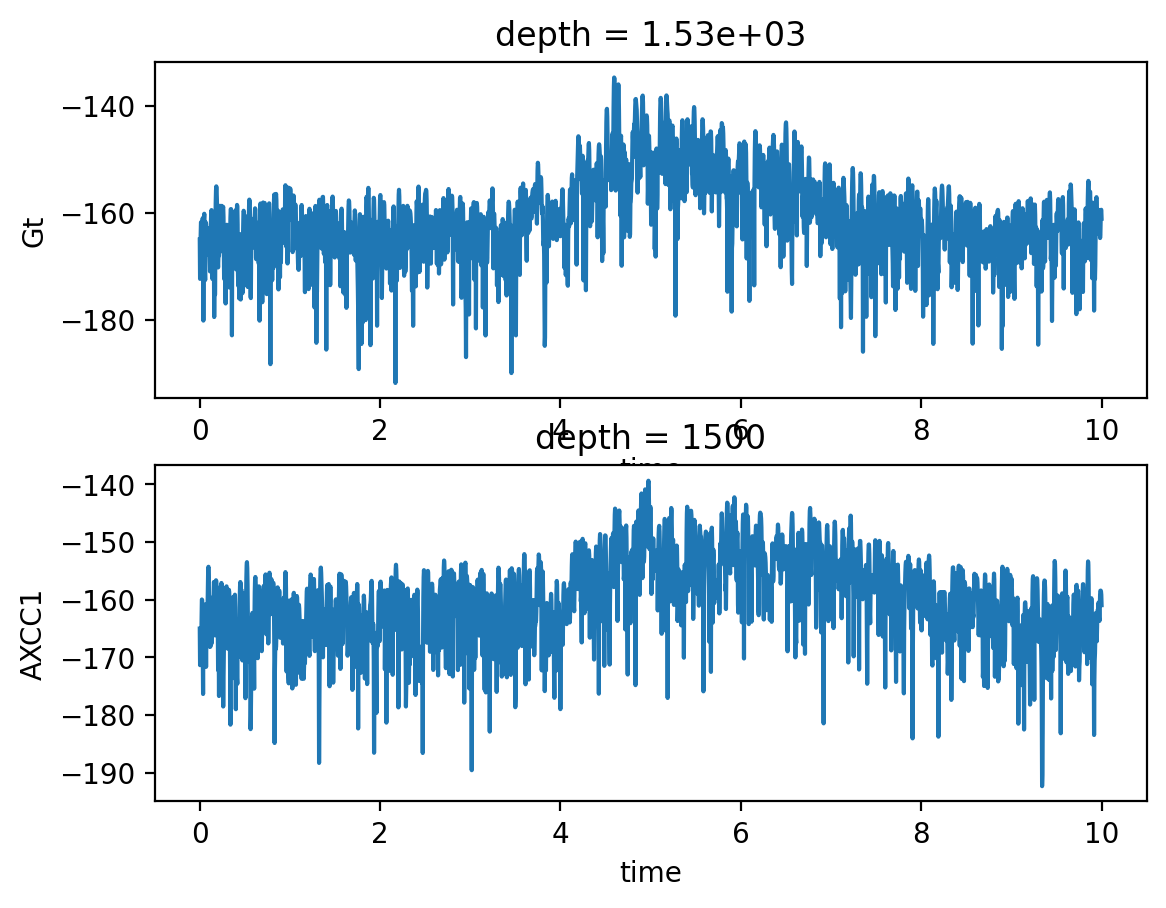

In [28]:
plt.subplot(2,1,1)
(20*np.log10(np.abs(Gts['AXCC1'][0]))).plot()

plt.subplot(2,1,2)
gts_climate_iw['AXCC1'].interp({'depth':1500}).plot()